https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras

# Import modules

In [661]:
from scipy.ndimage.interpolation import shift
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time

# Utils

In [662]:
def display_formatted_time(elapsed_time, msg=""):
    minutes, seconds = map(int, divmod(elapsed_time, 60));
    print("Elapsed time - {0}: {1}min {2}s".format(msg, minutes, seconds))

# Load data

In [663]:
df_origin = pd.read_csv("../../data/raw/international-airline-passengers.csv",
                                           usecols=[1],
                                           engine="python",
                                           skipfooter=3)

In [664]:
df_origin.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


In [665]:
df_origin.keys()

Index(['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [666]:
df_origin.shape

(144, 1)

# EDA

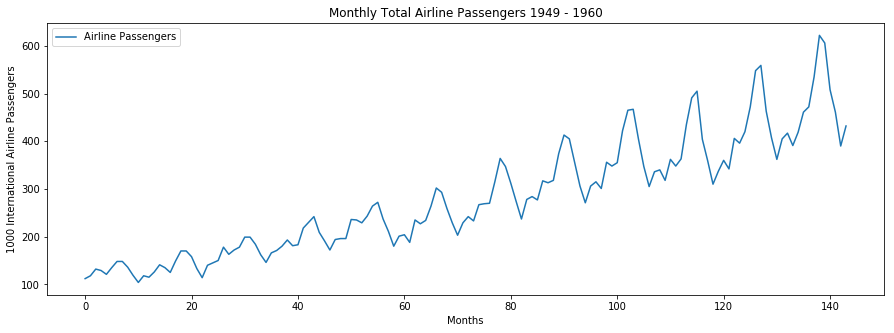

In [667]:
plt.figure(figsize=(15, 5))
plt.plot(df_origin,
              label="Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

# Data preparation

In [668]:
data_raw = df_origin.values.astype("float32")
data_raw[:10]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.]], dtype=float32)

## Scaling

In [669]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)
dataset[:10]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753]], dtype=float32)

## データセット整形 1

### Split into test / training data

In [705]:
train_size = 0.6
offset = int(len(dataset) * train_size)
X_train, X_test = dataset[:offset], dataset[offset:]

In [706]:
print("train set / test set: {} / {}".format(len(X_train), len(X_test)))

train set / test set: 86 / 58


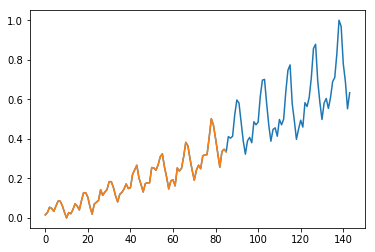

In [707]:
plt.plot(dataset)
plt.plot(X_train)

### 時系列データをKerasで使いやすいように整形

window_size 個のデータを使用し、次のタイムステップの値を予測する

In [716]:
def create_dataset(dataset, window_size=1):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        y.append(dataset[i + window_size, 0])
#     X = np.reshape(np.array(X), (np.array(X).shape[0], np.array(X).shape[1], 1))
    X = np.reshape(np.array(X), (np.array(X).shape[0], 1, np.array(X).shape[1]))
    y = np.reshape(np.array(y), ([-1, 1]))
#     X = np.reshape(np.array(X), [-1, window_size, 1])
 #    y = np.reshape(np.array(y), [-1, 1])
    return X, y

In [717]:
window_size = 12
X_train_seq, y_train_seq = create_dataset(X_train, window_size)
X_test_seq, y_test_seq = create_dataset(X_test, window_size)
print(X_train_seq.shape, y_train_seq.shape)

(74, 1, 12) (74, 1)


In [718]:
print(X_train_seq[0:2])
print(y_train_seq[0:2])

[[[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
   0.08494207 0.08494207 0.06177607 0.02895753 0.         0.02702703]]

 [[0.02702703 0.05405405 0.04826255 0.03281853 0.05984557 0.08494207
   0.08494207 0.06177607 0.02895753 0.         0.02702703 0.02123553]]]
[[0.02123553]
 [0.04247104]]


# Build simple LSTM model

In [719]:
model = Sequential()
model.add(LSTM(4,
                               input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(loss="mse",
                           optimizer="adam")

In [726]:
def fit_model(X, y, window_size=1):
    model = Sequential()
    model.add(LSTM(4,
                                   input_shape=(1, window_size)))
    model.add(Dense(1))
    model.compile(loss="mse",
                               optimizer="adam")
    model.fit(X,
                     y,
                     epochs=100,
                     batch_size=1,
                     verbose=1)
    return model

In [721]:
since = time.time()
model1 = fit_model(X_train_seq, y_train_seq, window_size)
display_formatted_time(time.time() - since)

Epoch 1/100
74/74 [==============================] - 5s 62ms/step - loss: 0.0194
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 3/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 4/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 5/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 6/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 8/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 9/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 10/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 11/100
74/74 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 12/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 13/100
74/74 [================

74/74 [==============================] - 0s 3ms/step - loss: 6.0758e-04
Epoch 99/100
74/74 [==============================] - 0s 2ms/step - loss: 6.7427e-04
Epoch 100/100
74/74 [==============================] - 0s 3ms/step - loss: 5.9099e-04
Elapsed time - : 0min 24s


## Predict

In [722]:
def predict_and_score(model, X, y):
    pred = scaler.inverse_transform(model.predict(X))
    y_true = scaler.inverse_transform(y)
    score = math.sqrt(mean_squared_error(y_true, pred[:, 0]))
    return score, pred

In [723]:
rmse_train, pred_train = predict_and_score(model1, X_train_seq, y_train_seq)
rmse_test, pred_test = predict_and_score(model1, X_test_seq, y_test_seq)

print("RMSE")
print("Train score: %.2f" % rmse_train)
print("Test score: %.2f" % rmse_test)

RMSE
Train score: 12.70
Test score: 29.44


# Plot

In [724]:
def plot_pred(dataset, pred_train, pred_test):
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[window_size:(len(pred_train) + window_size), :] = pred_train

    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[(len(pred_train) + window_size * 2):((len(pred_train) + window_size * 2) + len(pred_test)), :] = pred_test
    
    plt.figure(figsize=(15, 10))
    plt.plot(df_origin)
    plt.plot(train_predict_plot)
    plt.plot(test_predict_plot)

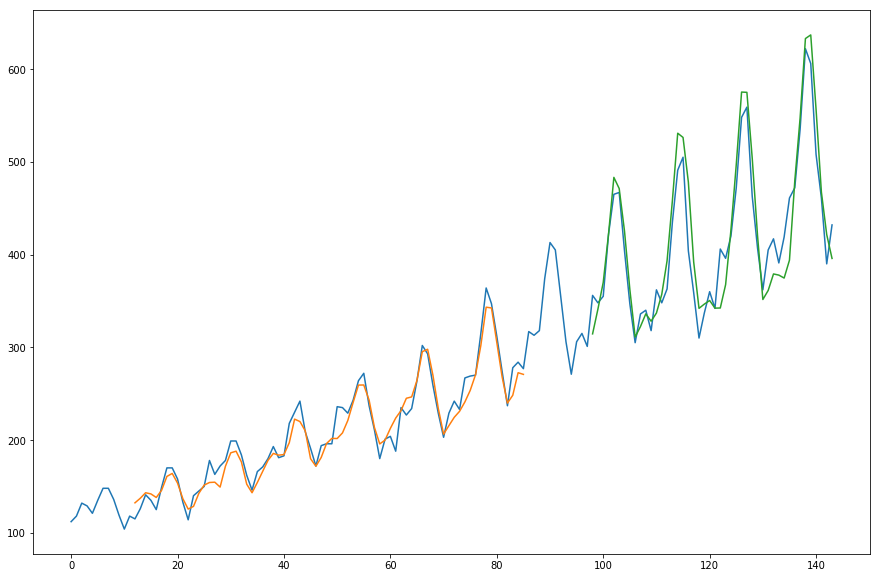

In [725]:
plot_pred(dataset, pred_train, pred_test)

In [727]:
def fit_model2(X, y, window_size=1):
    model = Sequential()
    model.add(LSTM(units=window_size,
                                   input_shape=(1, window_size),
                                   return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(512))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation("linear"))
    model.compile(loss="mse",
                               optimizer="adam")
    model.summary()
    model.fit(X,
                     y,
                     epochs=100,
                     batch_size=32,
                     verbose=1)
    return model

In [728]:
since = time.time()
model2 = fit_model2(X_train_seq, y_train_seq, window_size)
display_formatted_time(time.time() - since)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 1, 12)             1200      
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 12)             0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 512)               1075200   
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 513       
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0         
Total params: 1,076,913
Trainable params: 1,076,913
Non-trainable params: 0
_________________________________________________________________


74/74 [==============================] - 0s 743us/step - loss: 0.0025
Epoch 87/100
74/74 [==============================] - 0s 678us/step - loss: 0.0027
Epoch 88/100
74/74 [==============================] - 0s 721us/step - loss: 0.0024
Epoch 89/100
74/74 [==============================] - 0s 728us/step - loss: 0.0027
Epoch 90/100
74/74 [==============================] - 0s 794us/step - loss: 0.0019
Epoch 91/100
74/74 [==============================] - 0s 746us/step - loss: 0.0020
Epoch 92/100
74/74 [==============================] - 0s 749us/step - loss: 0.0044
Epoch 93/100
74/74 [==============================] - 0s 752us/step - loss: 0.0021
Epoch 94/100
74/74 [==============================] - 0s 792us/step - loss: 0.0021
Epoch 95/100
74/74 [==============================] - 0s 789us/step - loss: 0.0029
Epoch 96/100
74/74 [==============================] - 0s 766us/step - loss: 0.0030
Epoch 97/100
74/74 [==============================] - 0s 720us/step - loss: 0.0034
Epoch 98/100
74/7

In [729]:
rmse_train, pred_train = predict_and_score(model2, X_train_seq, y_train_seq)
rmse_test, pred_test = predict_and_score(model2, X_test_seq, y_test_seq)

print("Train score: %.2f" % rmse_train)
print("Test score: %.2f" % rmse_test)

Train score: 17.01
Test score: 35.77


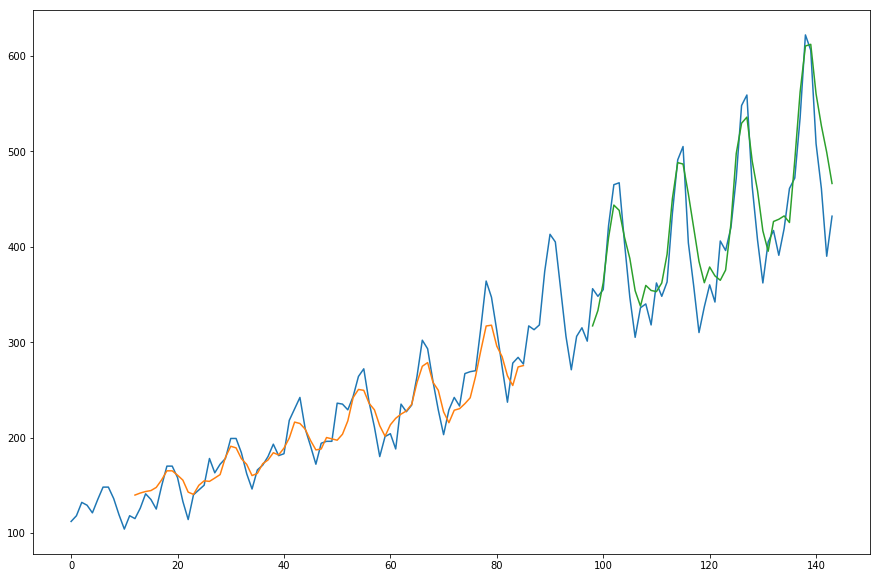

In [730]:
plot_pred(dataset, pred_train, pred_test)